<h1 style="background-color: #9E9A75; padding: 20px; color:white; fontsize:40px;">Part 2: Exploratory Data Analysis</h1>

# Table of Contents
1. [Import Libraries](#lib)
2. [Exploratory Data Analysis](#eda)
3. [Conclusion](#conclusion)
4. [References](#ref)

In [1]:
# Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


<a id='lib'></a>
# Import Libraries

In [2]:
# File processing
import os
from os import listdir
from os.path import isfile, join
import csv
import shutil
import PIL
from PIL import Image

# Analytics
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from tensorboard.plugins import projector

military_palette = ['#6B8E23', '#4B5320', '#78866B', '#FAD6A5', '#848482', '#2A3439', '#C3B091', '#000080', '#252525', '#BBA686']
sns.set_palette(military_palette)

import warnings
warnings.filterwarnings('ignore')

## Load Modified Dataset from Kaggle

In [3]:
!pip install kaggle

In [4]:
# CONSTANTS
DATA_DIR = '/content/dataset'
IMG_DIM = 100
CHANNEL = 3
IMG_SHAPE = (IMG_DIM, IMG_DIM, CHANNEL)

In [5]:
if not os.path.exists(DATA_DIR):
    # Create directory to store kaggle credentials
    !mkdir ~/.kaggle
    # Add kaggle.json file in your root folder
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    # Set Permissions
    !chmod 600 ~/.kaggle/kaggle.json
    # Download dataset
    !kaggle datasets download -d racheltanminzhi/landuse
    # Unzip folder
    !unzip /content/landuse.zip -d /content/dataset/
else:
    print('Directory already exists.')

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/recreational/recreational_00502.png  
  inflating: /content/dataset/recreational/recreational_00503.png  
  inflating: /content/dataset/recreational/recreational_00504.png  
  inflating: /content/dataset/recreational/recreational_00505.png  
  inflating: /content/dataset/recreational/recreational_00506.png  
  inflating: /content/dataset/recreational/recreational_00507.png  
  inflating: /content/dataset/recreational/recreational_00508.png  
  inflating: /content/dataset/recreational/recreational_00509.png  
  inflating: /content/dataset/recreational/recreational_00510.png  
  inflating: /content/dataset/recreational/recreational_00511.png  
  inflating: /content/dataset/recreational/recreational_00512.png  
  inflating: /content/dataset/recreational/recreational_00513.png  
  inflating: /content/dataset/recreational/recreational_00514.png  
  inflating: /content/dataset/recreational/recreational_00515.png

**Create Dataset**

In [6]:
# CONSTANTS
landuse_dict = {
    'highdensitybuildings':0,
    'lowdensitybuildings':1,
    'roads':2,
    'recreational':3,
    'harbor':4,
    'beach':5,
    'forest':6,
    'river':7,
    'runway':8,
    'storagetanks':9,
}
CLASSES = list(landuse_dict.keys())
NUM_CLASSES = len(CLASSES)

In [7]:
def create_ds(dir):
    filenames = []
    y = []
    for root, directories, files in os.walk(dir):
        for file in files:
            y.append(landuse_dict[root.split('/')[-1]])
            filenames.append(os.path.join(root, file))
    X = np.stack([(Image.open(file)).resize((IMG_DIM, IMG_DIM)) for file in filenames])
    y = np.array(y).reshape(-1, 1)
    return X, y

In [8]:
X, y = create_ds('/content/dataset')

**Train Test Split**<br>
For all our models, we will split the dataset into 80% for training and 20% for testing using the random state 42.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<a id='eda'></a>
# Exploratory Data Analysis

**Origin of dataset**<br>
To tackle our problem statement, we used the UCMerced (University of California Merced) Land Use dataset that we found on [Kaggle](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification).
Originally, the dataset contained 9501 satellite categorised into 21 classes, as shown below. However, we decided to combine similar classes together and focus on classifying 10 main areas that the military would encounter more frequently.
<img src="images/orig_classes.jpg" />


**The 10 new classes**
1. High density buildings
2. Low density buildings
3. Roads
4. Recreational
5. Harbor
6. Beach
7. Forest
8. River
9. Runway
10. Storage Tank

**General Information about the dataset**<br>
There are 7600 images in the train set and 1901 images in the test set. The samples are 256px by 256px coloured images.

In [10]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (7600, 100, 100, 3)
X_test shape: (1901, 100, 100, 3)
y_train shape: (7600, 1)
y_test shape: (1901, 1)


## Image Samples
**Images were already augmented**<br>
The black regions in some of the images is a result of a data augmentation (random rotation) by the contributor of the dataset. Originally, there were 100 images for each class but after augmentation, it increased to 500 for each class. We were concerned about that these black regions could confuse the model and affect its accuracy. However, we decided to continue using this dataset as it could serve as an occlusion that the drone might face in real life and it provides different perspectives of a location.

**Image Quality**<br>
At a quick glance, the image resolution is quite poor for the majority of images. The low colour contrast and similar muted colours across all classes could also pose a challenge to us when training the model.

In [11]:
def plot_samples(X, y, dataset):
    vals, idx_start, count = np.unique(y, return_counts=True, return_index=True)
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    plt.suptitle(f'Image Samples from {dataset} Set', size = 16, fontweight='bold', y = 1.0)

    for idx, ax in zip(idx_start, axes.flatten()):
        ax.imshow(X[idx], cmap='gray')
        ax.set_title(f'{CLASSES[y[idx][0]]}', size = 12)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

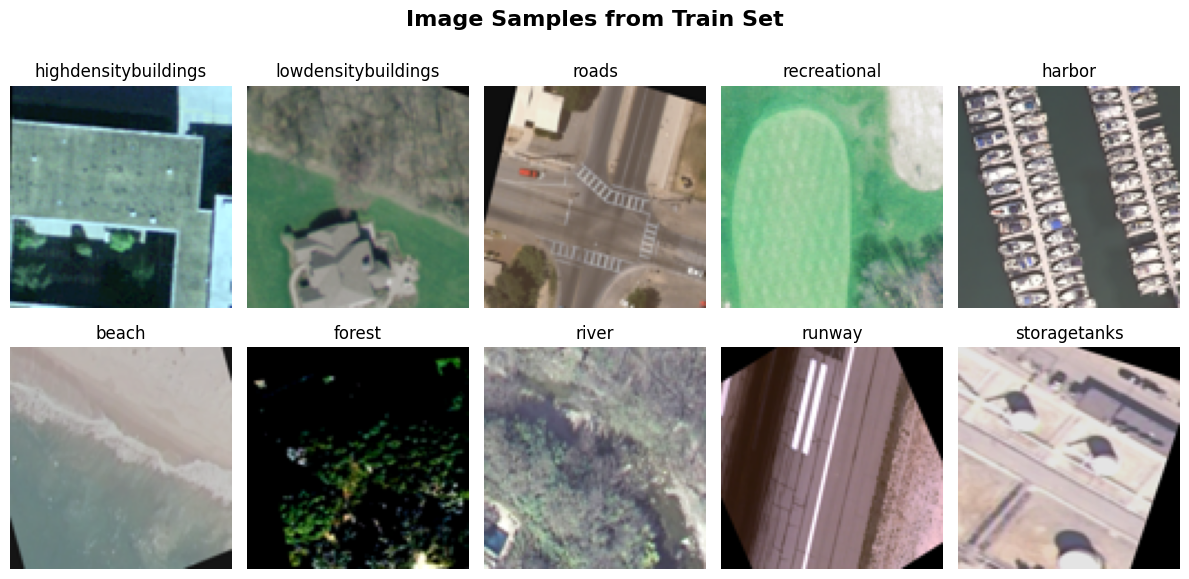

In [12]:
plot_samples(X_train, y_train, 'Train')

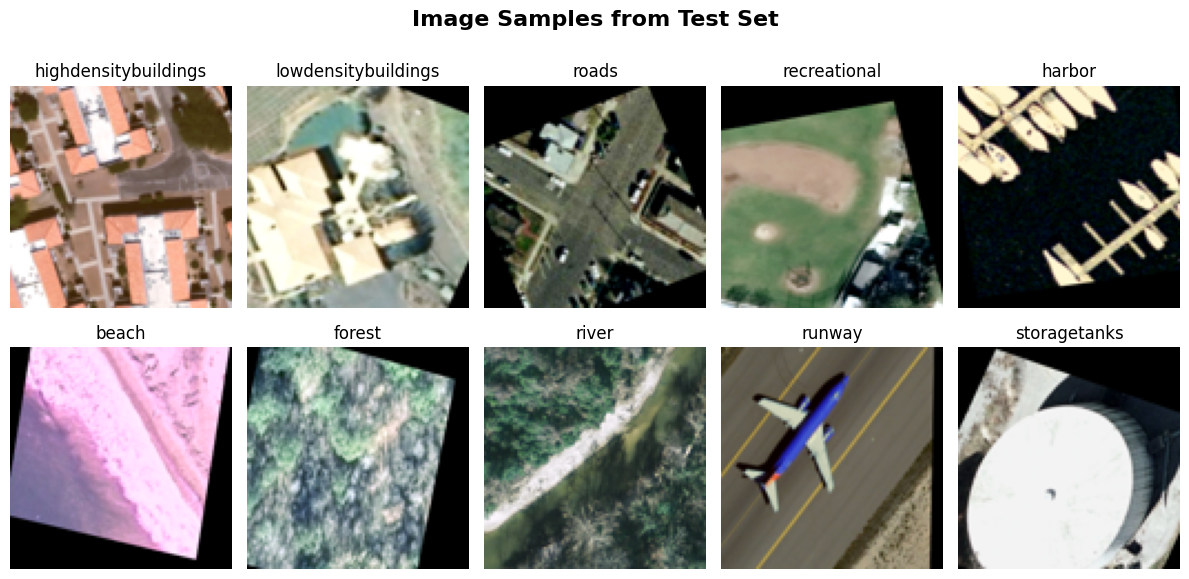

In [13]:
plot_samples(X_test, y_test, 'Test')

## Class Distribution
There is an imbalance in the distribution of classes. Across both the train and test sets, we have more images for the `Roads`, `Recreational`, `Runway`, and `Buildings related` classes. Conversely, the number of samples for the `Beach`, `River`, `Harbor`, `Storage Tanks`, and `Forest` classes are about 1/4 that of the `Roads` class each. Hence, we will do data augmentation and factor in the class weights during our training to prevent model bias. 

In [14]:
def plot_classdistribution(y, dataset):
    fig, ax = plt.subplots(figsize=(12, 6))
    # Reshape y
    y = y.reshape(-1)
    # Ordering labels
    ordered_vals = list(pd.Series(y).value_counts().index)
    ordered_labels = [CLASSES[i] for i in list(pd.Series(y).value_counts().index)]
    # Plot
    sns.countplot(x=y, hue=y, palette=military_palette, order = ordered_vals, legend=False)
    ax.set_title(f'Distribution of Classes in {dataset} set', size = 16, fontweight='bold')
    ax.set_xlabel('Class', size = 16)
    ax.set_xticklabels(labels=ordered_labels, size = 10, rotation = 20)
    ax.set_ylabel('Count', size = 16)
    sns.despine(top=True, right=True)
    # Annotations
    for p in ax.patches:
      x, y = p.get_x(), p.get_y() + p.get_height() + 0.025 * p.get_height()
      ax.annotate(int(y), (x+0.2, y), fontsize=12)
    plt.show()

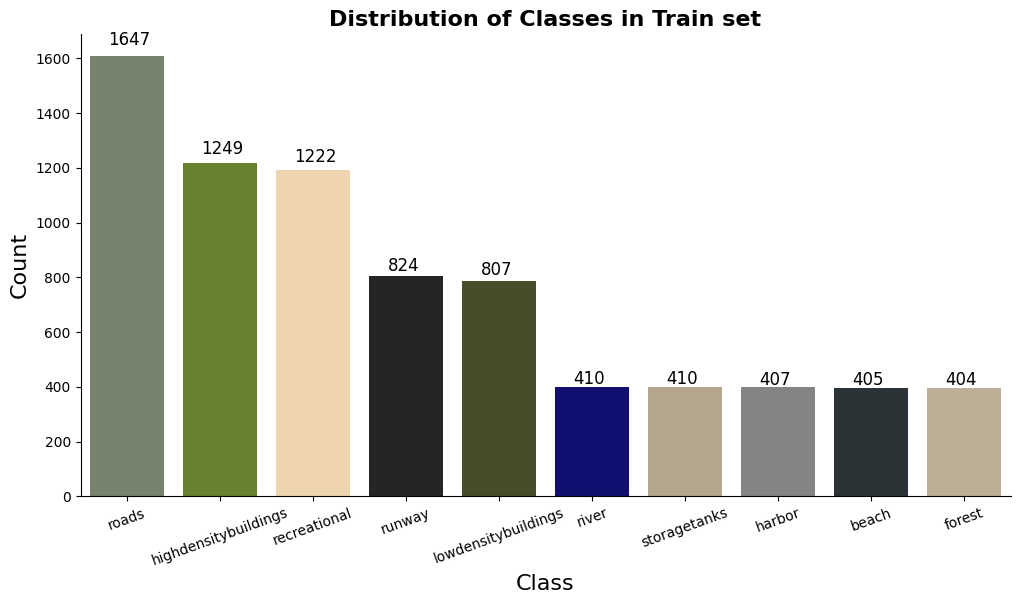

In [15]:
plot_classdistribution(y_train, 'Train')

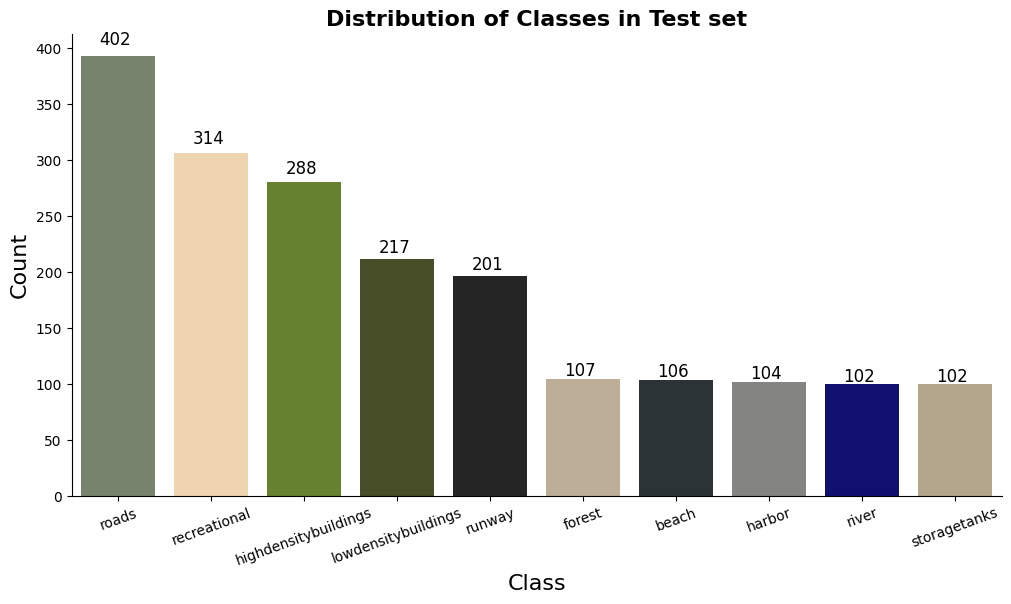

In [16]:
plot_classdistribution(y_test, 'Test')

# Class Weight
Classes with fewer samples would have a higher class weight value and by utilising it, we can penalise the misclassifications for the minority classes. We plotted out the weights for comparison.

In [17]:
def plot_classweight(y, dataset):
    y = y.reshape(-1)
    class_weights = dict(zip(np.unique(y), compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)))
    df_weights = pd.DataFrame({
        'class': CLASSES,
        'weights': class_weights.values()
    })

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(data=df_weights, x='class', y='weights', palette=military_palette)
    ax.set_title(f'Weights of Classes in {dataset} set', size = 16, fontweight='bold')
    ax.set_xlabel('Class', size = 16)
    ax.set_xticklabels(labels=CLASSES, size = 10, rotation = 20)
    ax.set_ylabel('Weights', size = 16)
    sns.despine(top=True, right=True)
    # Annotations
    for p in ax.patches:
        x, y = p.get_x(), p.get_y() + p.get_height() + 0.025 * p.get_height()
        ax.annotate(f'{y:.2f}', (x+0.2, y), fontsize=12)
    plt.show()

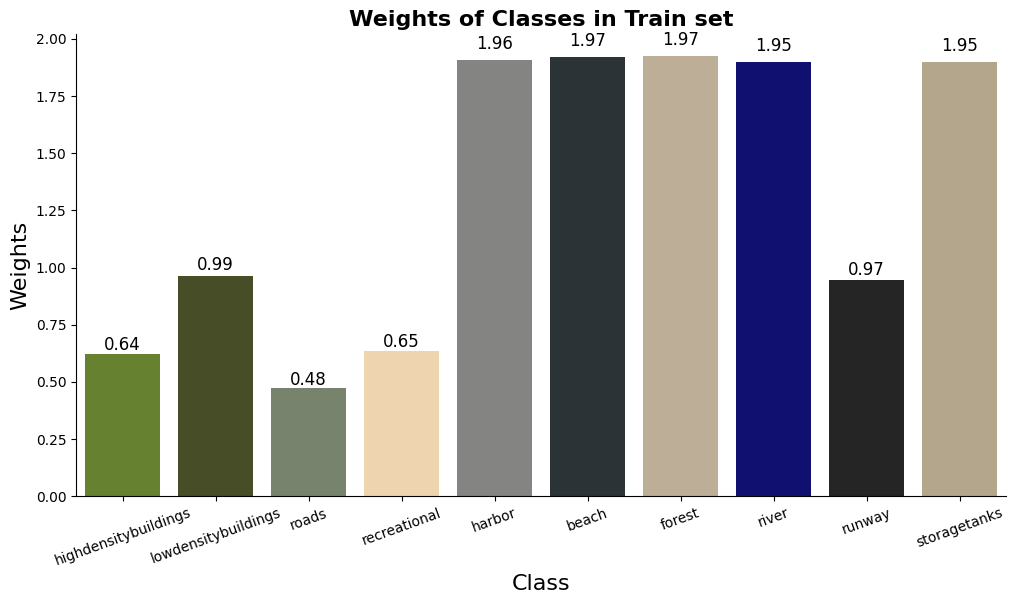

In [18]:
plot_classweight(y_train, 'Train')

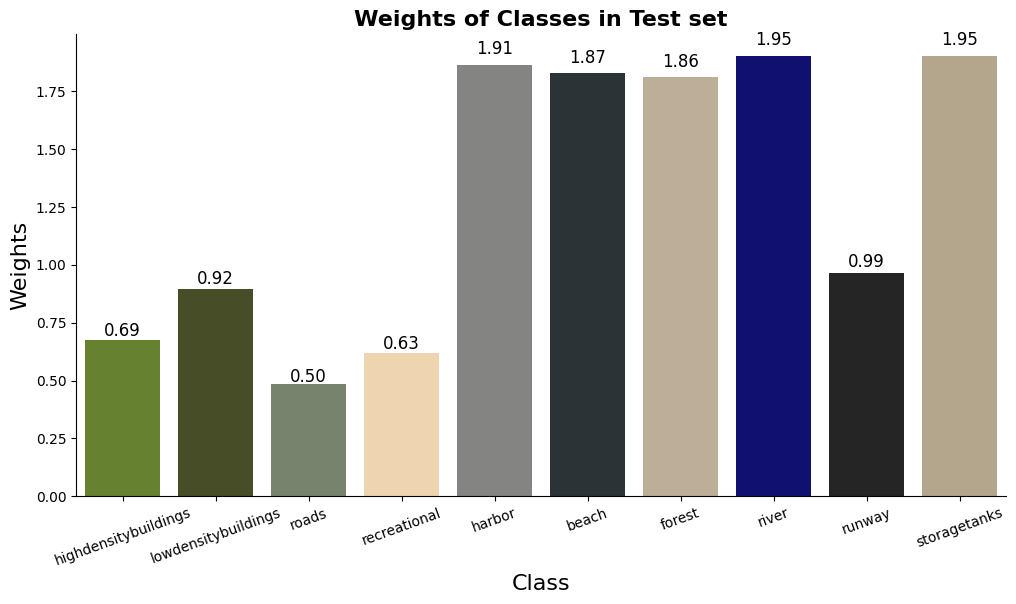

In [19]:
plot_classweight(y_test, 'Test')

## Pixel Distribution
We created a histogram of the mean grayscale and RGB image of each class to explore the image features without having to review all images.

**Based on the Grayscale Histogram**<br>
- **Image Brightness**: Images with a higher concentration of pixels to the left imply a darker image. If the concentration is towards the right, the image is lighter. Since all gray histograms are negatively skewed, the images are lighter in colour.

- **Image Contrast**: An even distribution of pixels suggest a high contrast. Since all histograms are restricted to a small region, it implies that most images have low contrast.

**Based on the RGB Histograms**<br>
<img src="images/rgb.png" width="200" />
- Based on the overlaps of the RGB histograms, we can infer the colours in the images.
- At a glance, we noticed a similar pattern across all graphs: all 3 channels are left skewed and there are overlaps amongst the 3 peaks. This suggests the presence of white undertones and the possibility that there are a wide variety of colours in the images. 
- There are a few dominant peaks which suggests that the images are oversaturated.

In [20]:
def pixel_distribution(X, y, dataset):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for num, ax in zip(range(0, 10), axes.ravel()):
        all_imgs = X[y.reshape(-1) == num]
        # Calculate mean of image
        mean_img = np.mean(all_imgs, axis = 0)
        # Flattened image
        sns.histplot(mean_img.ravel(), bins=256, color='black', alpha=0.3, ax=ax)
        sns.histplot(mean_img[:, :, 0].ravel(), bins=256, color='red', alpha=0.3, ax=ax)
        sns.histplot(mean_img[:, :, 1].ravel(), bins=256, color='green', alpha=0.3, ax=ax)
        sns.histplot(mean_img[:, :, 2].ravel(), bins=256, color='blue', alpha=0.3, ax=ax)
        sns.despine(top=True, right=True)
        ax.set_title(f'{CLASSES[num]}', size=16)
        ax.set_ylabel('Count', size=12)
    plt.suptitle(f'Distribution of Pixels in {dataset} set', size=20, fontweight='bold', y = 1.0)
    plt.tight_layout()
    plt.show()

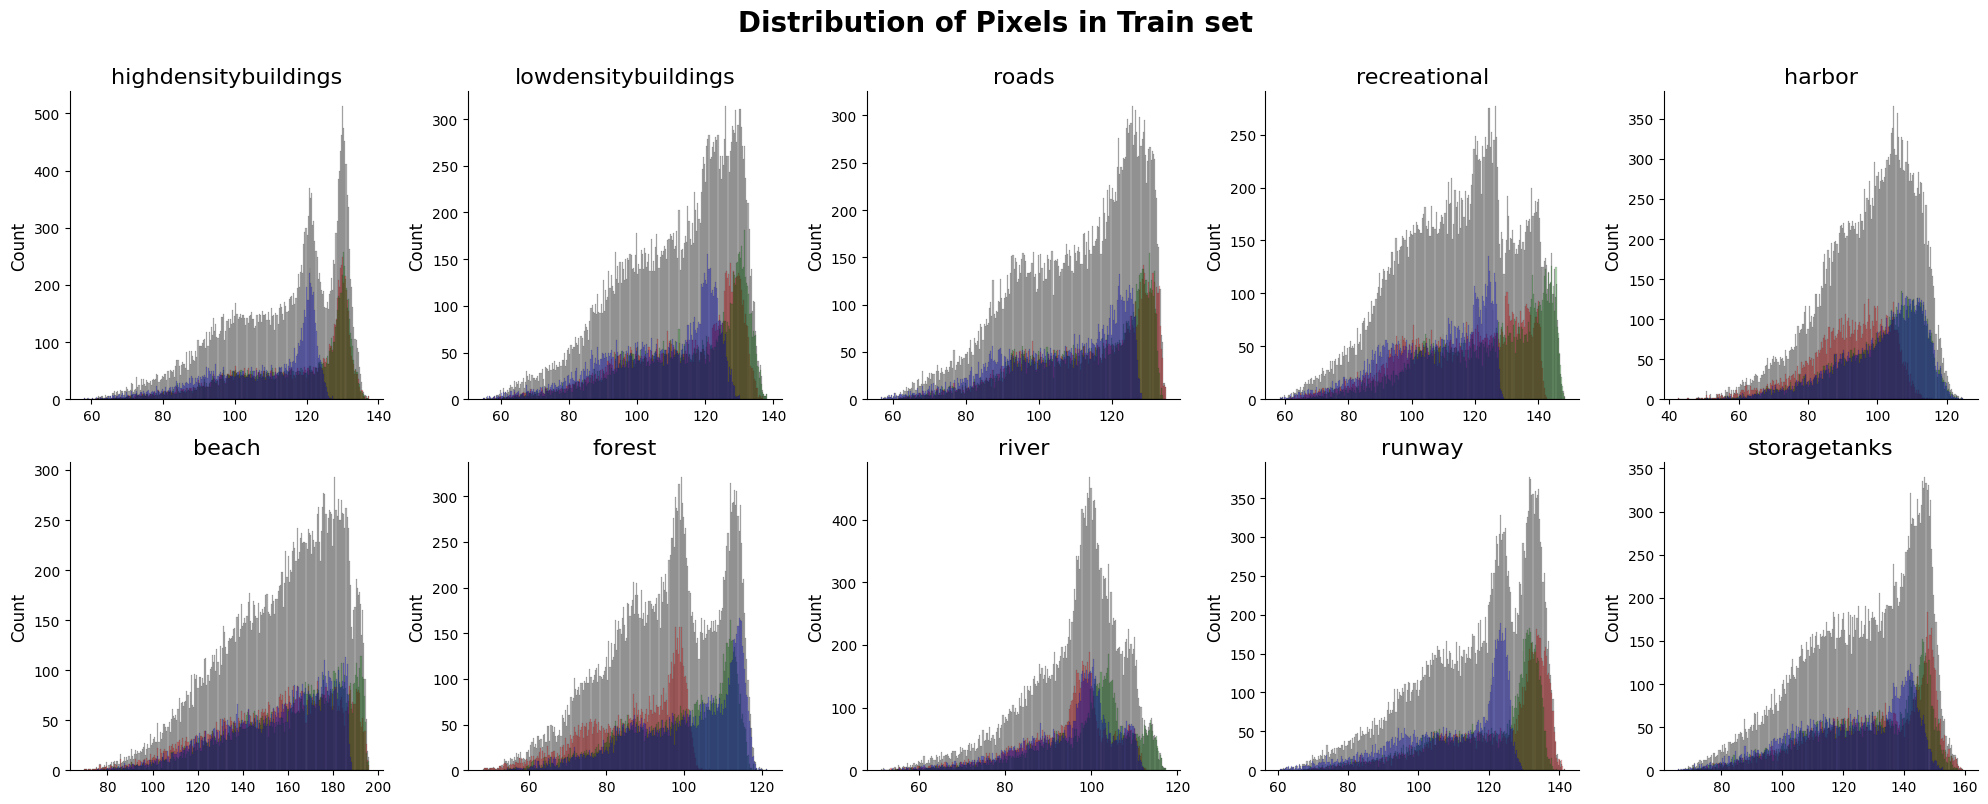

In [21]:
pixel_distribution(X_train, y_train, 'Train')

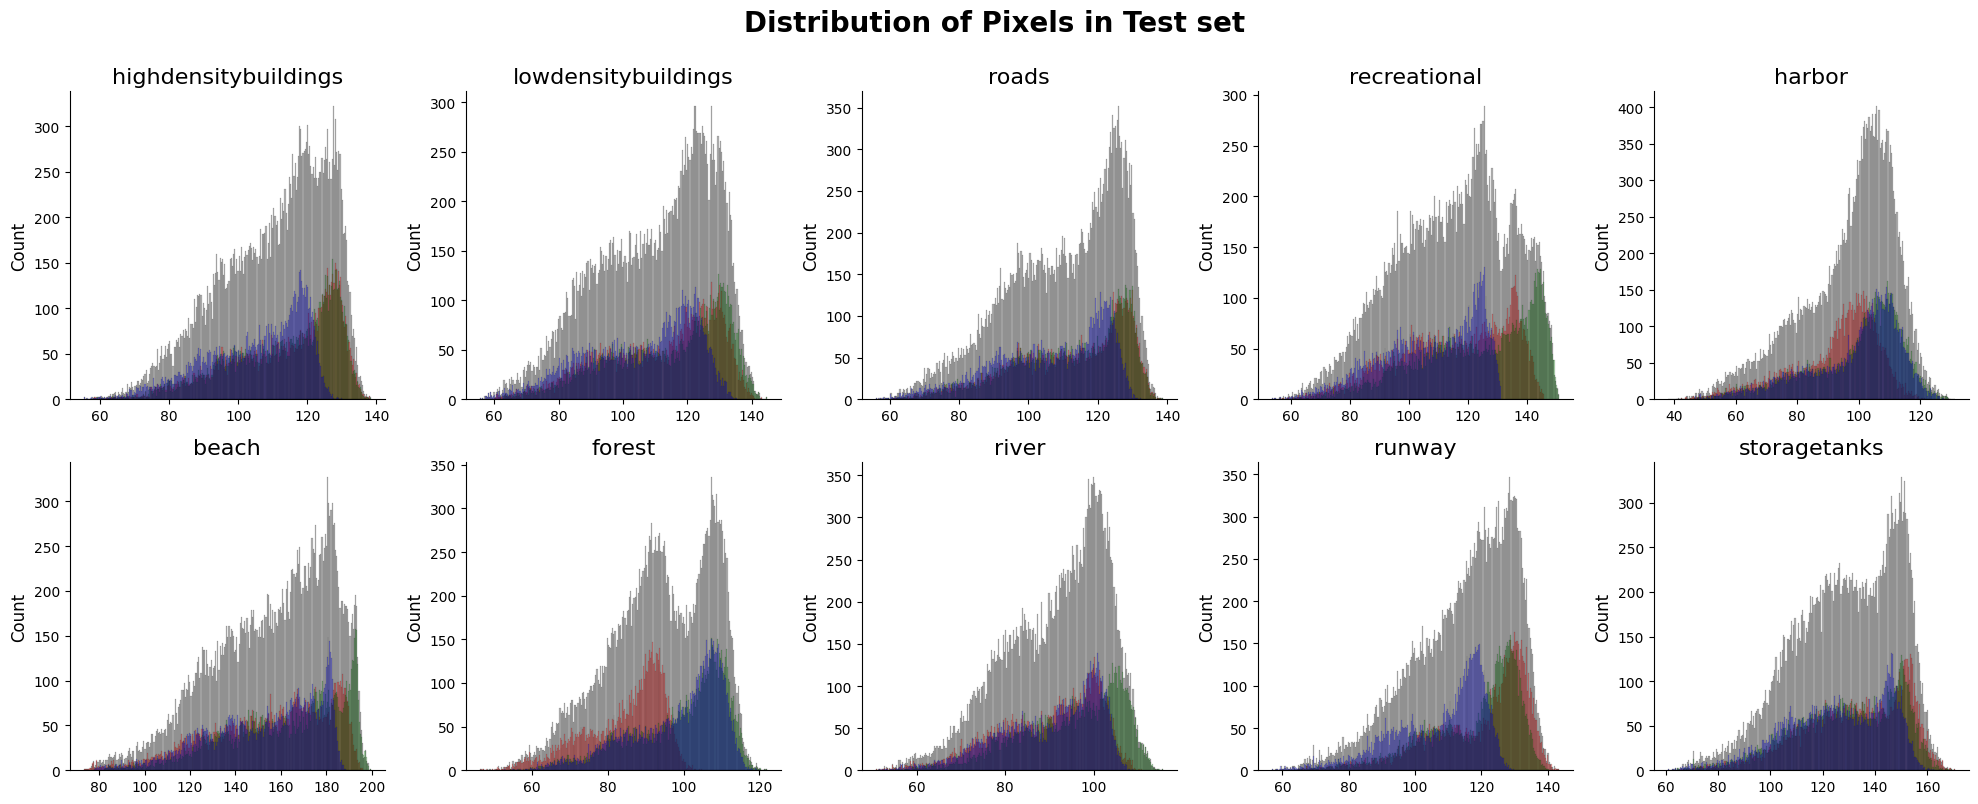

In [22]:
pixel_distribution(X_test, y_test, 'Test')

## Projection Embeddings
Using TensorBoard, we projected the embeddings to check for any obvious clusters in our dataset. To do this, we created a sprite image with some image samples and calculated the embeddings for these samples.

In [23]:
# height and width of embeddings
height, width = 224, 224
batch_size = 10

**Generate Sprite Image**<br>
A sprite image contains a subset of images from the dataset. Our sprite image has a dimension of 25 x 25, so in total we used 625 images.

In [24]:
def generate_sprite_image(images, image_width, image_height, layout):
    """
    Generate a sprite image from a list of images with a specified layout.

    Args:
    - images: A list of NumPy arrays representing the images.
    - image_width: Width of each individual image in pixels.
    - image_height: Height of each individual image in pixels.
    - layout: A tuple containing the number of rows and columns for the sprite image layout.

    Returns:
    - sprite_image: A PIL Image object representing the sprite image.
    """

    # Calculate the number of images and required sprite image size
    num_images = len(images)
    num_rows, num_cols = layout
    sprite_width = num_cols * image_width
    sprite_height = num_rows * image_height

    # Create a new RGBA mode image with transparent background
    sprite_image = Image.new(mode='RGBA', size=(sprite_width, sprite_height), color=(0, 0, 0, 0))

    # Paste each image into the sprite image
    for idx, image in enumerate(images):
        row_idx = idx // num_cols
        col_idx = idx % num_cols
        x_offset = col_idx * image_width
        y_offset = row_idx * image_height
        paste_box = (x_offset, y_offset, x_offset + image_width, y_offset + image_height)
        sprite_image.paste(Image.fromarray(image), paste_box)

    # Save sprite image
    sprite_path = 'sprite.png'
    sprite_image.save(sprite_path)
    print(f'Sprite image saved to {sprite_path}')
    return sprite_image

In [ ]:
SPRITE_DIM = 25
num_selected = SPRITE_DIM * SPRITE_DIM
X_samples = X_train[:num_selected,:,:,:]
generate_sprite_image(X_train, IMG_DIM, IMG_DIM, (SPRITE_DIM, SPRITE_DIM))

<img src='images/sprite.png' />

**Feature Extraction with MobileNet**<br>
We chose a pre-trained model, MobileNetv2 as the feature extractor due to its small size and efficient network. MobileNetv2 requires images to be resized to 224px x 224px and normalized, so we performed the necessary transformations before running an operation to extract the features.

In [26]:
tf.compat.v1.disable_eager_execution()
# Open the feature vectors file for writing
image_data = tf.compat.v1.placeholder(tf.float32, shape=(None, IMG_DIM, IMG_DIM, 3))
image = tf.image.resize(image_data, [height, width])
# Obtain the features from the module
module = hub.load("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5")
features = module(image)

In [27]:
with open('feature_vecs.tsv', 'w') as fw:
    csv_writer = csv.writer(fw, delimiter='\t')

    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())
        for image in X_samples:
            image_data_resized = np.expand_dims(image, axis=0)
            # Run the 'features' operation to extract feature vectors
            fvecs = sess.run(features, feed_dict={image_data: image_data_resized})
            # Write the feature vectors to the 'feature_vecs.tsv' file
            csv_writer.writerow(fvecs.flatten())  # Write as a flattened row

**Setting up the Projecter Configuration**<br>
Files required:
- `feature_vecs`.tsv: embeddings
- `metadata.tsv`: labels for each embedding
- `sprite.png`: sprite iamges
- `projector_config.pbtxt`: configuration file that stores the file path to the files above

In [28]:
# Set up projector config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_path = 'feature_vecs.tsv'

# Write labels to metadata file
metadata_path = 'metadata.tsv'
y_samples = y_train[:num_selected,:]
with open(metadata_path, 'w') as metadata_file:
    for label in y_samples:
        metadata_file.write(f'{CLASSES[label[0]]}\n')
embedding.metadata_path = metadata_path

# Add path to the sprite image
embedding.sprite.image_path = 'sprite.png'
embedding.sprite.single_image_dim.extend([IMG_DIM, IMG_DIM])
projector.visualize_embeddings('.', config)

In [29]:
%load_ext tensorboard

Please run the notebook if you would like to view the projected embeddings. On the right of the navigation bar, select `Projector`. For any other options you won't see anything.

The projection uses PCA embedding (can select another option) for dimensionality reduction and utilises the first three principal components. It uses the cosine distance (can select another option) to determine the similarity.

<img src="images/axes.png" width="200" />
The <span style="color:red">red line represents the x axis</span>, the <span style="color:green">green line represents the y axis</span>, and the <span style="color:blue">blue line represents the z axis</span>.

In [ ]:
%tensorboard --logdir .

<a id='conclusion'></a>
# Conclusion
From the EDA, it is clear that we will have some issues with the prediction due to the imbalance in classes, poor image quality, and the lack of clear clusters in the dataset, especially among roads, storage tanks, and building-related classes. Hence, we will experiment with various models to determine which can produce the best performance.

---

<a id='ref'></a>
# References
https://www.allaboutcircuits.com/technical-articles/image-histogram-characteristics-machine-learning-image-processing/

https://medium.com/@juanabascal78/exploratory-image-analysis-part-2-embeddings-on-tensorboard-a13a5d4f98b0